<center><h1><u>Car Price Prediction</u></h1></center>

## Problem statement

- Predict the selling price of the used car using given data.

## Machine Learning problem
 - Supervised Learning
 - Regression
 - Metrics : RMSE, MAE

## About dataset
This dataset contains the information of used cars.<br>
Source : https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho

### Attributes
   - <b>Car_Name</b> : Name of the cars<br><br>
   - <b>Year</b> : Year of the car when it was bought<br><br>
   - <b>Selling_price</b> : Price at which the car is being sold. (Target)<br><br>
   - <b>Present_price</b> : Current ex-showroom price of the car.<br><br>
   - <b>Kms_Driven</b> : Number of Kilometres the car is driven<br><br>
   - <b>Fuel_Type</b> : Fuel type of car (petrol / diesel / CNG / LPG / electric)<br><br>
   - <b>Seller_Type</b> : Tells if a Seller is Individual or a Dealer<br><br>
   - <b>Transmission</b> : Gear transmission of the car (Automatic/Manual)<br><br>
   - <b>Owner</b> : Number of previous owners of the car.

## Libraries and utility functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

from feature_engine.encoding import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

import warnings
warnings.filterwarnings('ignore')


In [2]:

# utility functions

#get validation rmse and mae values
def get_scores(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

#add NO of years attribute
class AtributeAdder(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        temp = X.copy()
        temp.loc[:, 'No_of_Yrs'] = 2021 - data.Year
        temp.drop('Year', axis=1, inplace=True)
        return temp
    
# K-fold cross validation
def run_clf_kfold(regressor, X_train, y_train, k):
    l=[]
    folds = KFold(n_splits = k)
    for i, (train_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        print(f'\n------------- Fold {i + 1} -------------')
        ###### Get train, and valid sets ######
        ### Training Set
        X_trn, y_trn = X_train.iloc[train_idx], y_train.iloc[train_idx]
        ### Validation Set
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
        ## get rmse
        rmse = get_scores(regressor, X_trn, X_val, y_trn, y_val)
        print(f'\nRMSE for validation set is {rmse}')
        l.append(rmse)
    print("\nMean Rmse :", sum(l)/k)

In [3]:
# Read data into memory

data = pd.read_csv("car data.csv")

## Exploratory data analysis

In [4]:
data.head(3)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0


In [5]:
# data dimensions

data.shape

(301, 9)

In [6]:
#Null values

data.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [7]:
# Unique values

data.nunique()

Car_Name          98
Year              16
Selling_Price    156
Present_Price    147
Kms_Driven       206
Fuel_Type          3
Seller_Type        2
Transmission       2
Owner              3
dtype: int64

In [8]:
# Removing Car_Name because of high cardinality

data.drop('Car_Name', axis=1, inplace=True)

In [9]:
# data types

data.dtypes

Year               int64
Selling_Price    float64
Present_Price    float64
Kms_Driven         int64
Fuel_Type         object
Seller_Type       object
Transmission      object
Owner              int64
dtype: object

In [10]:
# Numerical features

num_features = data.select_dtypes(include=np.number).columns.tolist()
print(num_features)

['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']


In [11]:
# Categorical features

cat_features = data.select_dtypes(exclude=np.number).columns.tolist()
print(cat_features)

['Fuel_Type', 'Seller_Type', 'Transmission']


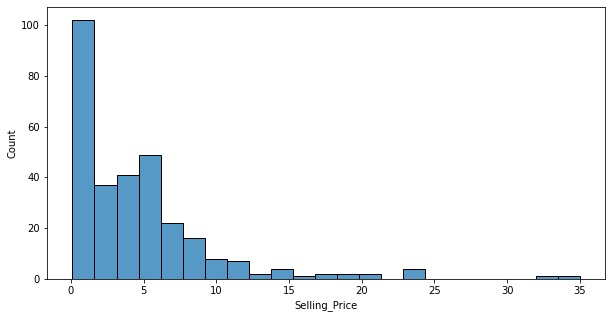

In [12]:
# Target distribution/ Selling price

fig = plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='Selling_Price')
plt.show()

### categorical variables

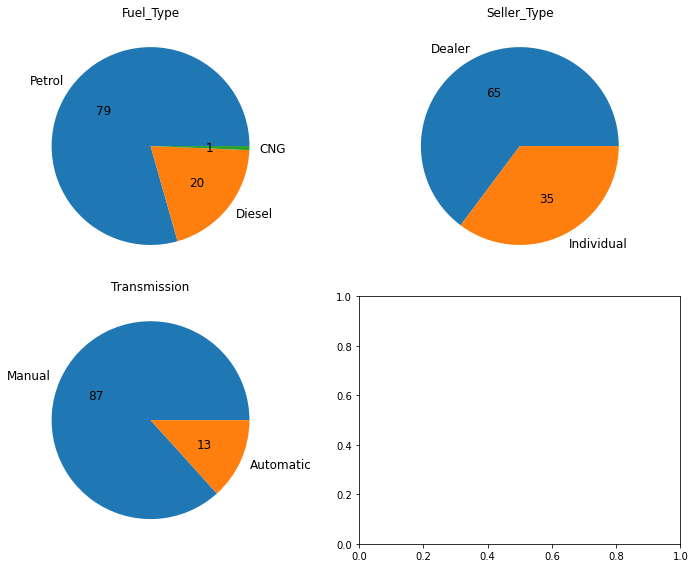

In [13]:
# Pie charts

fig, axes = plt.subplots(2,2, figsize=(10,8))
axes = [ax for axes_row in axes for ax in axes_row]

for i,c in enumerate(cat_features):
    _ = data[c].value_counts().plot(kind='pie', ax=axes[i], title=c, autopct="%.0f", fontsize=12)
    _ = axes[i].set_ylabel('')
_ = plt.tight_layout()

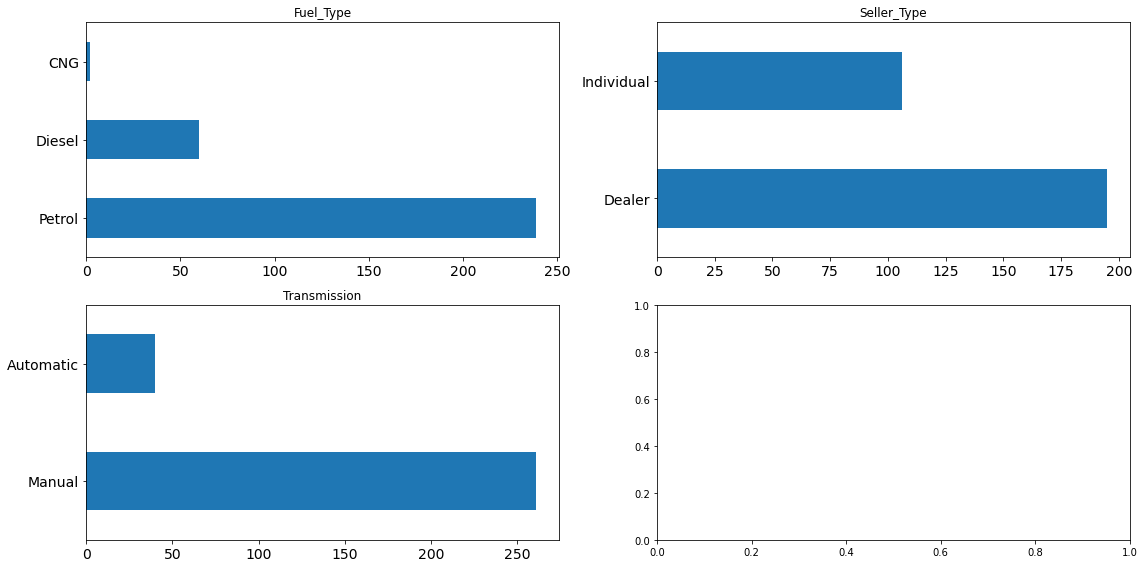

In [14]:
# bar plots

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(cat_features):
    _ = data[c].value_counts().plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

### Numerical features

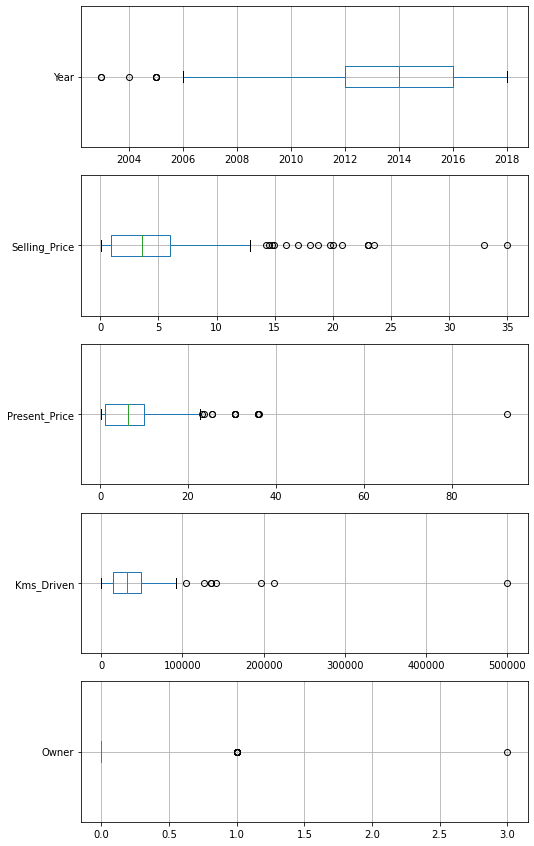

In [15]:
# Box plots

fig, axes = plt.subplots(5, 1, figsize=(8, 15))
for i, c in enumerate(num_features):
    _ = data[[c]].boxplot(ax=axes[i], vert=False)

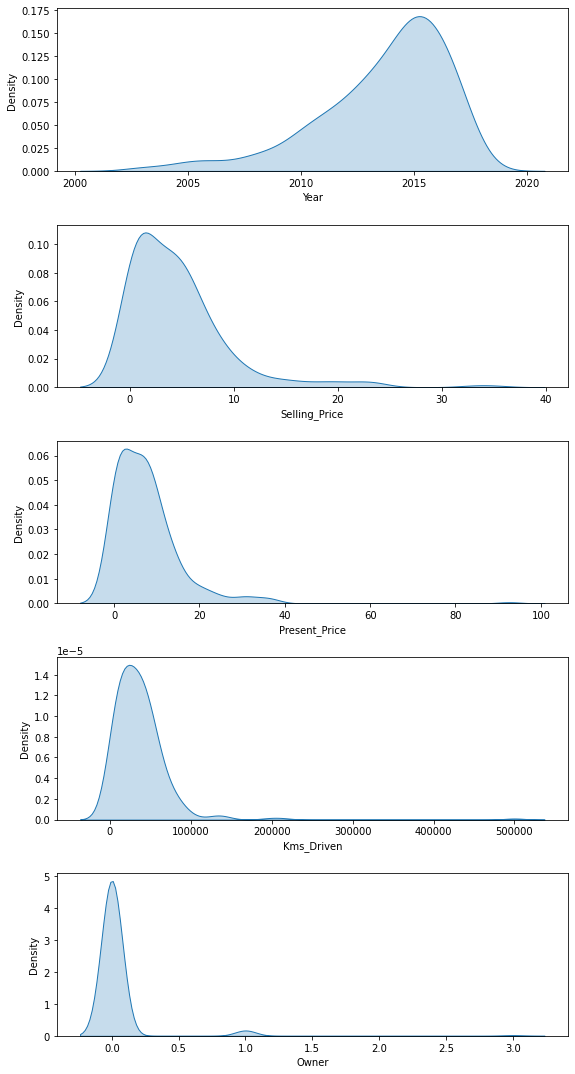

In [16]:
# Density plots

fig, axes = plt.subplots(5, 1, figsize=(8, 15))
for i, c in enumerate(num_features):
    plot = sns.kdeplot(data=data, x=c, ax=axes[i], fill=True)
plt.tight_layout()

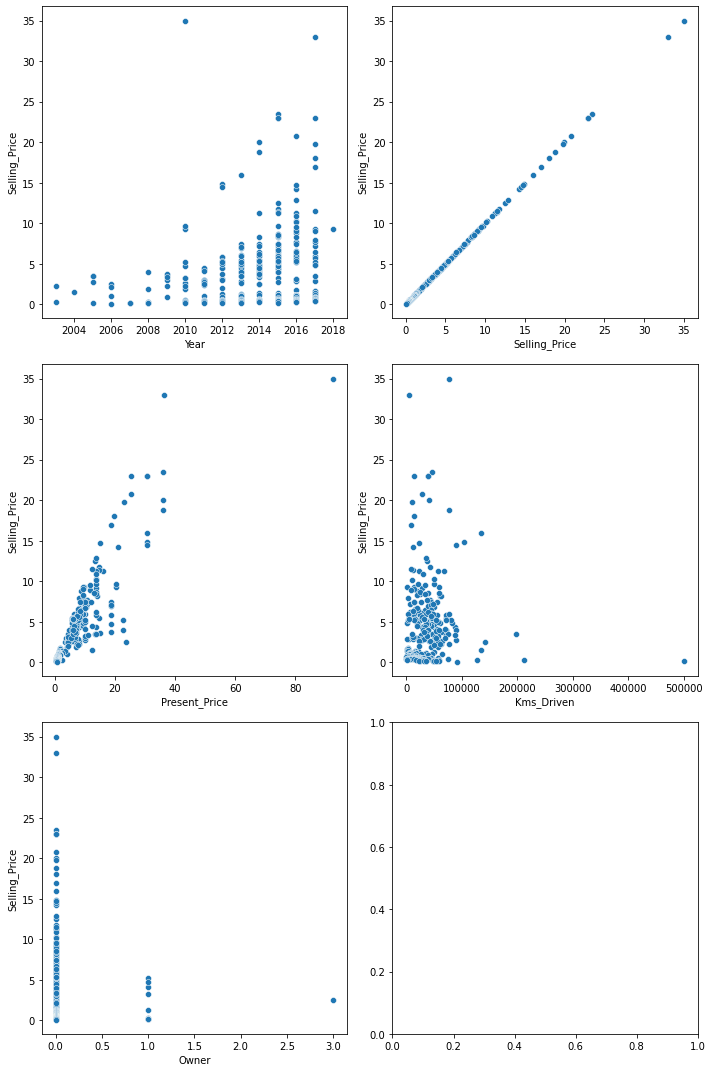

In [17]:
# Scatter plot

fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(num_features):
    f = sns.scatterplot(data=data, x=c, y='Selling_Price', ax=axes[i]) 
    
_ = plt.tight_layout()

## Feature engineering

In [18]:
data.head(3)

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0


In [19]:
X = data.drop('Selling_Price', axis=1)
y = data.Selling_Price

In [20]:
pipe = Pipeline(steps=[
    ("attribute adder", AtributeAdder()),
    
    ('one hot encoder', OneHotEncoder(variables=cat_features)),
    
    ('min max scaler', SklearnTransformerWrapper( variables = ['Kms_Driven'],
                                                 transformer=MinMaxScaler(feature_range=(0, 100) ) ) )
    
])

In [21]:
pipe.fit(X)

Pipeline(steps=[('attribute adder', AtributeAdder()),
                ('one hot encoder',
                 OneHotEncoder(variables=['Fuel_Type', 'Seller_Type',
                                          'Transmission'])),
                ('min max scaler',
                 SklearnTransformerWrapper(transformer=MinMaxScaler(feature_range=(0,
                                                                                   100)),
                                           variables=['Kms_Driven']))])

In [22]:
prepared_X = pipe.transform(X)

In [23]:
prepared_X.head()

,Present_Price,Kms_Driven,Owner,No_of_Yrs,Fuel_Type_Petrol,Fuel_Type_Diesel,Fuel_Type_CNG,Seller_Type_Dealer,Seller_Type_Individual,Transmission_Manual,Transmission_Automatic
0,5.59,5.305305,0,7,1,0,0,1,0,1,0
1,9.54,8.508509,0,8,0,1,0,1,0,1,0
2,9.85,1.281281,0,4,1,0,0,1,0,1,0
3,4.15,0.940941,0,10,1,0,0,1,0,1,0
4,6.87,8.398398,0,7,0,1,0,1,0,1,0


## Feature selection

In [24]:
# Embedding method

model = ExtraTreesRegressor(random_state=1)
model.fit(prepared_X, y)

ExtraTreesRegressor(random_state=1)

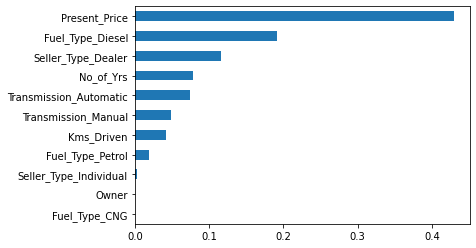

In [25]:
#feature importances

feat_importances = pd.Series(model.feature_importances_, index=prepared_X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

Note : Since we only have few features, I have selected all the features for modelling.

In [26]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(prepared_X, y, test_size=0.20, random_state = 1)

# Machine learning

## Base model : Decision tree

In [27]:
# DT regressor
rmse = get_scores(DecisionTreeRegressor(random_state=1), X_train, X_test, y_train, y_test)
print("Rmse for base DT model:", rmse)

Rmse for base DT model: 1.1201405064090668


In [28]:
# Hyperparameter tuning

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12, 14, 16],
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128,256]
}

search = RandomizedSearchCV(DecisionTreeRegressor(random_state=1),
                         hyperparam_combs,
                         scoring='neg_mean_squared_error',
                         random_state=1,
                         n_iter=20,
                         cv=3)

search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=1),
                   n_iter=20,
                   param_distributions={'criterion': ['mse', 'friedman_mse',
                                                      'mae', 'poisson'],
                                        'max_depth': [4, 6, 8, 10, 12, 14, 16],
                                        'max_features': [0.2, 0.4, 0.6, 0.8, 1],
                                        'max_leaf_nodes': [8, 16, 32, 64, 128,
                                                           256],
                                        'min_samples_split': [2, 10, 20, 30,
                                                              40]},
                   random_state=1, scoring='neg_mean_squared_error')

In [29]:
search.best_params_

{'min_samples_split': 2,
 'max_leaf_nodes': 256,
 'max_features': 0.6,
 'max_depth': 6,
 'criterion': 'mse'}

In [30]:
# Best DT model
model = DecisionTreeRegressor(random_state=1, **search.best_params_)
get_scores(model, X_train, X_test, y_train, y_test)

1.9840824832379464

## K-Fold cross validation

In [31]:
run_clf_kfold(model, X_train, y_train, k=5)


------------- Fold 1 -------------

RMSE for validation set is 1.2482061616540172

------------- Fold 2 -------------

RMSE for validation set is 2.4169963251802082

------------- Fold 3 -------------

RMSE for validation set is 2.624256147308826

------------- Fold 4 -------------

RMSE for validation set is 1.4091141184332487

------------- Fold 5 -------------

RMSE for validation set is 3.513022135076599

Mean Rmse : 2.2423189775305796


## Random forest model


In [32]:
# RF regressor
rmse = get_scores(RandomForestRegressor(random_state=1), X_train, X_test, y_train, y_test)
print("Rmse for RF model:", rmse)

Rmse for RF model: 1.5895049873838185


In [33]:
# Hyperparameter tuning

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 1000, num = 12)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(1, 30, num = 6)],
               'min_samples_split': [2, 5, 10, 15],
               'min_samples_leaf': [1, 2, 5, 10]}


search = RandomizedSearchCV(RandomForestRegressor(random_state=1),
                         random_grid,
                         scoring='neg_mean_squared_error',
                         random_state=1,
                         n_iter=10,
                         cv=3,
                         verbose=1)

search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
                   param_distributions={'max_depth': [1, 6, 12, 18, 24, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [50, 136, 222, 309, 395,
                                                         481, 568, 654, 740,
                                                         827, 913, 1000]},
                   random_state=1, scoring='neg_mean_squared_error', verbose=1)

In [34]:
search.best_params_

{'n_estimators': 222,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 18}

In [35]:
# Best RF model
best_model = RandomForestRegressor(random_state=1, **search.best_params_)
get_scores(best_model, X_train, X_test, y_train, y_test)

1.867189280575611

## K-fold cross validation

In [40]:
run_clf_kfold(best_model, X_train, y_train, k=5)


------------- Fold 1 -------------

RMSE for validation set is 1.1306522491934035

------------- Fold 2 -------------

RMSE for validation set is 0.9809173086782472

------------- Fold 3 -------------

RMSE for validation set is 1.8614416182969773

------------- Fold 4 -------------

RMSE for validation set is 0.9289170537917607

------------- Fold 5 -------------

RMSE for validation set is 3.453483097823477

Mean Rmse : 1.6710822655567732


# Evaluate the best model

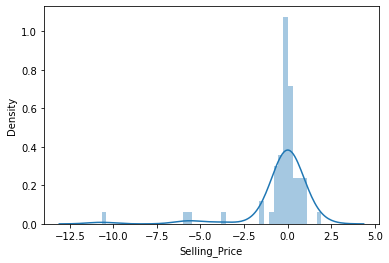

In [37]:
best_model.fit(X_train, y_train)

predictions=best_model.predict(X_test)

#distribution of errors
sns.distplot(y_test-predictions)
plt.show()

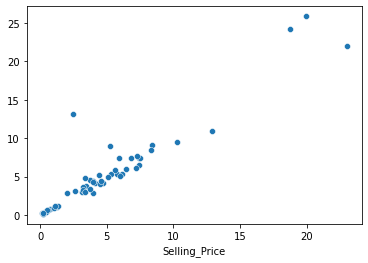

In [38]:
# scatter plot

sns.scatterplot(x=y_test, y=predictions)
plt.show()

In [39]:
print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

MAE: 0.7969973452268523
MSE: 3.486395809496468
RMSE: 1.867189280575611


## Save the model and preprocessing pipeline

In [48]:
with open("pipe.pkl", 'wb') as f:
    pickle.dump(pipe, f)

with open("best_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
#####################Checking pickle files##############################

In [50]:
with open("pipe.pkl", 'rb') as f:
    pipe = pickle.load(f)

with open("best_model.pkl", 'rb') as f:
    model = pickle.load(f)

In [64]:
def predict(ex):
    columns = ['Year','Present_Price','Kms_Driven','Fuel_Type','Seller_Type', 'Transmission','Owner']
    df = pd.DataFrame([ex], columns=columns)
    x = pipe.transform(df)
    y = model.predict(x)
    return round(y[0],2)

In [72]:
ex = [2016, 10.59, 27000, 'Petrol', 'Dealer', 'Manual', 0 ]
predict(ex)

6.86